In [1]:
import os
import time
import copy
import glob
import cv2
import shutil

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
# parameters
batch_size = 128
epoch = 50
class_num = 4
data_path = '../dataset/resnet_dataset/onepiece'
result_path = 'result'
folder_name = f'onepiece_epoch{epoch}'

In [3]:
# 모델의 파라미터 학습 유무 설정
def set_parameter_requires_grad(model, feature_extracting= True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = feature_extracting

In [4]:
# 모델 학습 함수
def train_model(model, dataloaders, criterion, optmizer, device, result_path, name, num_epochs= 3):
    since = time.time()
    os.makedirs(f'{result_path}/{name}', exist_ok= True)
    print(f'{result_path}/{name}')
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optmizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optmizer.step()

            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)

        # save parameters
        
        torch.save(model.state_dict(), f'{result_path}/{name}/{epoch:03}.pth')

        epoch_end = time.time()
        print('epoch time : ', epoch_end - epoch_start)

    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history, loss_history

In [5]:
# 이미지 데이터 전처리 방법 정의
trsf = transforms.Compose([transforms.Resize([256, 256]),
                           transforms.RandomResizedCrop(224),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor()])

train_dataset = torchvision.datasets.ImageFolder(data_path, transform= trsf)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size= batch_size,
                                           num_workers= 12,
                                           shuffle= True)

print('num of train set is', len(train_dataset))

num of train set is 5777


In [6]:
# 사전 훈련된 모델, 파라미터 학습 허용
model_res50 = models.resnet50(pretrained= True)
set_parameter_requires_grad(model_res50, True)

# 완전연결층 추가
model_res50.fc = nn.Linear(2048, class_num)

print(model_res50)

# 파라미터 값 확인
for name, param in model_res50.named_parameters():
    if param.requires_grad:
        print(name, param.data)

c:\Users\USER\anaconda3\envs\env02\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\anaconda3\envs\env02\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# 전체 파라미터 개수
total_parameters = sum(p.numel() for p in model_res50.parameters())

# 학습 가능 파라미터
trainable_parameters = sum(p.numel() for p in model_res50.parameters() if p.requires_grad)

print(total_parameters)
print(trainable_parameters)

23516228
23516228


In [8]:
# 모델 객체 생성, 손실 함수 정의
model = models.resnet50(pretrained= True)

for param in model.parameters(): # 합성곱층 가중치 고정
    param.required_grad = True

model.fc = torch.nn.Linear(2048, class_num)
for param in model.fc.parameters(): # 완전연결층은 학습
    param.requires_grad = True

opt = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# 전체 파라미터 개수
total_parameters = sum(p.numel() for p in model.parameters())

# 학습 가능 파라미터
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad == True)

print(total_parameters)
print(trainable_parameters)

23516228
23516228


In [10]:
# 학습 결과를 옵티마이저에 전달

params_to_update = []

for name, param in model_res50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print('\t', name)

opt = optim.Adam(params_to_update)

	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downs

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
#train_acc_hist, train_loss_hist = train_model(model_res50, train_loader, criterion, opt, device, result_path, folder_name, epoch)

In [12]:
# 테스트 데이터 호출, 전처리

test_path = '../dataset/resnet_dataset/onepiece_test'

trsf = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

test_dataset = torchvision.datasets.ImageFolder(
    root= test_path,
    transform= trsf
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size= 128,
    num_workers= 1,
    shuffle= True
)

print(len(test_dataset))

200


In [16]:
# 테스트 데이터 평가 함수

def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob(f'{result_path}/{folder_name}/*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path, map_location= device))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            #print(preds)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print(f'Acc: {epoch_acc}')

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print(f'Val complete in {time_elapsed // 60}m {time_elapsed * 60}s')
    print(f'Best Acc: {best_acc}')

    return acc_history

In [17]:
# 평가
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model_dict = torch.load('result/onepiece_epoch50/049.pth', map_location= device)
model_res50.load_state_dict(model_dict)

cpu


<All keys matched successfully>

In [18]:
val_acc_hist = eval_model(model_res50, test_loader, device)

saved_model ['result/onepiece_epoch50\\000.pth', 'result/onepiece_epoch50\\001.pth', 'result/onepiece_epoch50\\002.pth', 'result/onepiece_epoch50\\003.pth', 'result/onepiece_epoch50\\004.pth', 'result/onepiece_epoch50\\005.pth', 'result/onepiece_epoch50\\006.pth', 'result/onepiece_epoch50\\007.pth', 'result/onepiece_epoch50\\008.pth', 'result/onepiece_epoch50\\009.pth', 'result/onepiece_epoch50\\010.pth', 'result/onepiece_epoch50\\011.pth', 'result/onepiece_epoch50\\012.pth', 'result/onepiece_epoch50\\013.pth', 'result/onepiece_epoch50\\014.pth', 'result/onepiece_epoch50\\015.pth', 'result/onepiece_epoch50\\016.pth', 'result/onepiece_epoch50\\017.pth', 'result/onepiece_epoch50\\018.pth', 'result/onepiece_epoch50\\019.pth', 'result/onepiece_epoch50\\020.pth', 'result/onepiece_epoch50\\021.pth', 'result/onepiece_epoch50\\022.pth', 'result/onepiece_epoch50\\023.pth', 'result/onepiece_epoch50\\024.pth', 'result/onepiece_epoch50\\025.pth', 'result/onepiece_epoch50\\026.pth', 'result/onepiec

In [ ]:
#plt.plot(train_acc_hist, label= 'train')
plt.plot(val_acc_hist, label= 'val')
plt.legend()
plt.show()

#plt.plot(train_loss_hist)
#plt.show()

In [ ]:
# 예측 이미지 출력을 위한 전처리 함수

def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    # clone() : 기존 텐서의 내용을 복사
    # detach() : 기존 텐서에서 기울기가 전파되지 않는 텐서
    image = image.transpose(1, 2, 0)
    image = image*(np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1)

    return image

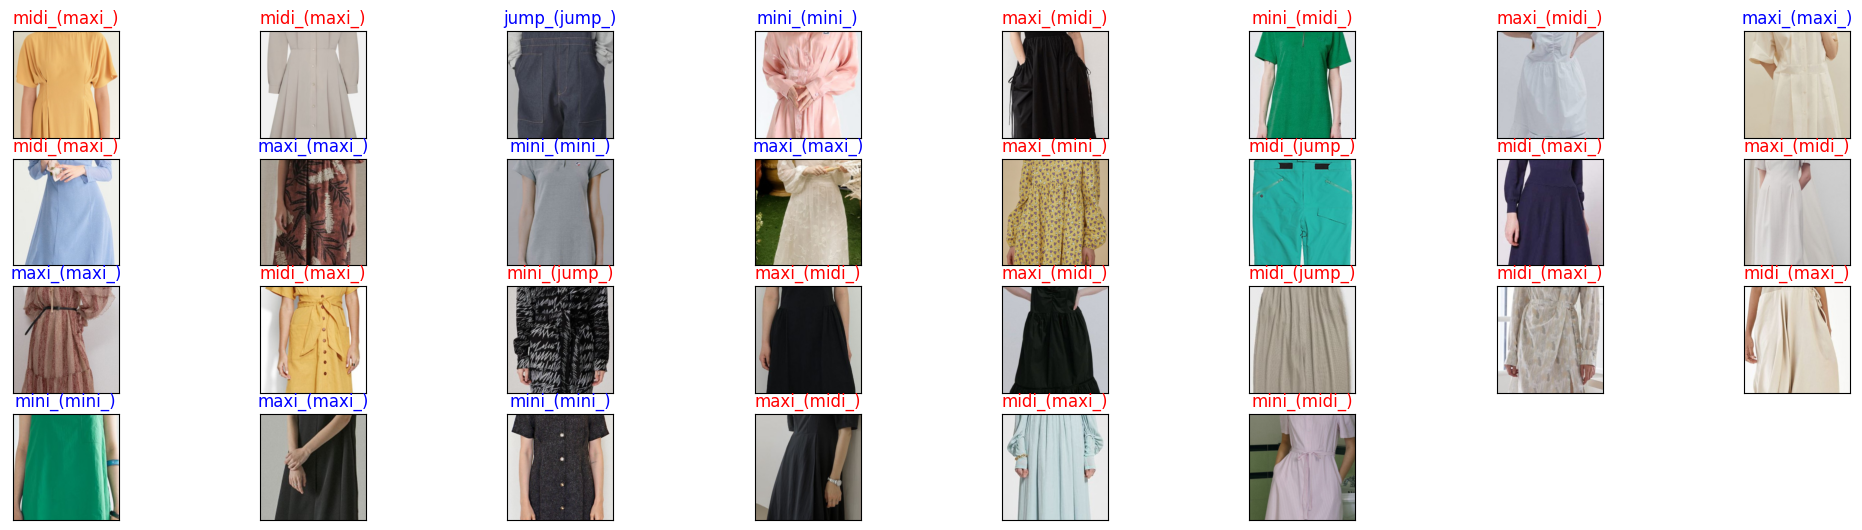

<Figure size 640x480 with 0 Axes>

In [ ]:
# 예측 결과 출력

classes = {0 : 'jump_suite', 1 : 'maxi_onepiece', 2 : 'midi_onepiece', 3 : 'mini_onepiece'}

dataiter = iter(test_loader)
images, labels = next(dataiter)
output = model_res50(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize= (25, 8))
for idx in np.arange(30):
    ax = fig.add_subplot(5, 8, idx + 1, xticks= [], yticks= [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])
    ax.set_title(f'{classes[preds[idx].item()][:5]}({classes[labels[idx].item()][:5]})', color= ('blue' if preds[idx] == labels[idx] else 'red'))
    # 일치하면 green, 불일치하면 red

plt.show()
plt.subplots_adjust(bottom= 0.2, top= 0.6, hspace= 0)